In [2]:
!hostname

Dellable


In [3]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"   
import random

import numpy as np
import pandas as pd
from numpy import matlib as mb
import matplotlib.pyplot as plt
import scipy.io

import seaborn as sns
sns.set_style("darkgrid")

import random
import matplotlib.lines as mlines

from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.metrics import (r2_score, f1_score, accuracy_score, 
                             roc_curve, roc_auc_score, mean_squared_error)

import scipy.interpolate as interp
from scipy import interpolate, signal
import scipy.ndimage
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
#import mat73

In [4]:
import neuralop
from neuralop.models import FNO
from neuralop.training import Trainer, AdamW
from neuralop.losses import LpLoss

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [6]:
filename='ITER_like_equilibrium_dataset.mat'
mat = scipy.io.loadmat(filename)
...
for key,val in mat.items():
    print(key)
    exec(key + '=val')

__header__
__version__
__globals__
DB_meas_Bpickup_test_ConvNet
DB_psi_pixel_test_ConvNet
DB_res_RHS_pixel_test_ConvNet
DB_Jpla_pixel_test_ConvNet
DB_coils_curr_test_ConvNet
RR_pixels
ZZ_pixels
DB_separatrix_200_test_ConvNet
XP_YN
DB_f_test_ConvNet
DB_p_test_ConvNet


In [7]:
DTYPE = 'float32'
DB_meas_Bpickup_test_ConvNet = mat['DB_meas_Bpickup_test_ConvNet'].astype(DTYPE)
DB_coils_curr_test_ConvNet   = mat['DB_coils_curr_test_ConvNet'].astype(DTYPE)
DB_p_test_ConvNet            = mat['DB_p_test_ConvNet'].astype(DTYPE)
res_RHS_pixel_data_load      = mat['DB_res_RHS_pixel_test_ConvNet'].astype(DTYPE)
RR_pixels                    = mat['RR_pixels'].astype(DTYPE)
ZZ_pixels                    = mat['ZZ_pixels'].astype(DTYPE)
DB_res_RHS_pixel_test_ConvNet   = mat['DB_res_RHS_pixel_test_ConvNet'].astype(DTYPE)
DB_separatrix_200_test_ConvNet  = mat['DB_separatrix_200_test_ConvNet'].astype(DTYPE)
XP_YN                           = mat["XP_YN"]                    # optional (diverted vs limiter)
DB_psi_pixel_test_ConvNet    = mat['DB_psi_pixel_test_ConvNet'].astype(DTYPE)
DB_Jpla_pixel_test_ConvNet   = mat['DB_Jpla_pixel_test_ConvNet'].astype(DTYPE)
print("DB_meas_Bpickup_test_ConvNet shape:", DB_meas_Bpickup_test_ConvNet.shape)
print("DB_coils_curr_test_ConvNet shape:   ", DB_coils_curr_test_ConvNet.shape)
print("DB_p_test_ConvNet shape:            ", DB_p_test_ConvNet.shape)
print("DB_psi_pixel_test_ConvNet shape:    ", DB_psi_pixel_test_ConvNet.shape)
print("RR_pixels shape:                    ", RR_pixels.shape)
print("ZZ_pixels shape:                    ", ZZ_pixels.shape)
print("XP_YN shape:                        ", XP_YN.shape)
print("DB_separatrix_200_test_ConvNet shape:", DB_separatrix_200_test_ConvNet.shape)
print("res_RHS_pixel_data_load shape:      ", res_RHS_pixel_data_load.shape)
print("DB_Jpla_pixel_test_ConvNet:",DB_Jpla_pixel_test_ConvNet.shape)

DB_meas_Bpickup_test_ConvNet shape: (81986, 187)
DB_coils_curr_test_ConvNet shape:    (81986, 14)
DB_p_test_ConvNet shape:             (81986, 101)
DB_psi_pixel_test_ConvNet shape:     (81986, 64, 64)
RR_pixels shape:                     (64, 64)
ZZ_pixels shape:                     (64, 64)
XP_YN shape:                         (1, 81986)
DB_separatrix_200_test_ConvNet shape: (81986, 200, 2)
res_RHS_pixel_data_load shape:       (81986, 64, 64)
DB_Jpla_pixel_test_ConvNet: (81986, 64, 64)


In [ ]:
del mat

In [8]:
X_data = np.column_stack([
    DB_meas_Bpickup_test_ConvNet,
    DB_coils_curr_test_ConvNet,
    DB_p_test_ConvNet
])

y_data = DB_psi_pixel_test_ConvNet

In [11]:
num_samples = X_data.shape[0] -75000
indices = np.arange(num_samples)

id_train, id_test = train_test_split(indices, test_size=0.3, random_state=42)

X_train = X_data[id_train, :]
X_test  = X_data[id_test, :]

y_train = y_data[id_train, :, :]
y_test  = y_data[id_test, :, :]

In [ ]:
del X_data
del y_data

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [13]:
n_r = y_train.shape[1]
n_z = y_train.shape[2]
out_size = n_r*n_z
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FNO(
    n_modes = (8, 8),
    in_channels = X_data.shape[1],
    out_channels = 1,
    hidden_channels = 64
)

model = model.to(device)

In [14]:
class FNODataset(Dataset):
    def __init__(self, data, labels):
        self.data = data.astype(np.float32)
        self.labels = labels.astype(np.float32)
        _, self.h, self.w = labels.shape

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        scalar_features = self.data[idx]  # shape (num_features,)
        x = np.broadcast_to(scalar_features[:, None, None],
                            (scalar_features.shape[0], self.h, self.w))
        x = torch.from_numpy(np.ascontiguousarray(x))

        y = torch.from_numpy(self.labels[idx][None, :, :])
        return {'x': x, 'y': y}

In [15]:
train_dataset = FNODataset(X_train, y_train)
test_dataset = FNODataset(X_test, y_test)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [17]:
class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x, **kwargs):
        # Only pass the 'x' tensor to the actual model, ignore other kwargs like 'y'
        return self.model(x)

# Wrap your model
wrapped_model = ModelWrapper(model).to(device)

In [18]:
trainer = Trainer(
    model=wrapped_model,
    n_epochs=20,
    data_processor=None,
    verbose=True
)

optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)

trainer.train(
    train_loader=train_loader,
    test_loaders={64: test_loader},
    optimizer=optimizer,
    scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20),
    training_loss=LpLoss(d=2, p=2, reduction='sum'),
    eval_losses={"l2": LpLoss(d=2, p=2, reduction='sum')}
)

Training on 4890 samples
Testing on [2096] samples         on resolutions [64].
Raw outputs of shape torch.Size([64, 1, 64, 64])


C:\Users\AxisS\AppData\Roaming\Python\Python313\site-packages\neuralop\training\trainer.py:536: UserWarning: LpLoss.__call__() received unexpected keyword arguments: ['x']. These arguments will be ignored.
  loss += training_loss(out, **sample)


[0] time=234.38, avg_loss=0.6227, train_err=39.5450
Eval: 64_l2=0.2381
[1] time=218.79, avg_loss=0.1678, train_err=10.6561
Eval: 64_l2=0.2018
[2] time=216.80, avg_loss=0.1247, train_err=7.9172
Eval: 64_l2=0.1884
[3] time=216.35, avg_loss=0.1078, train_err=6.8460
Eval: 64_l2=0.0955
[4] time=3767.96, avg_loss=0.0803, train_err=5.0988
Eval: 64_l2=0.1131
[5] time=617.25, avg_loss=0.0767, train_err=4.8712
Eval: 64_l2=0.1057
[6] time=593.08, avg_loss=0.0685, train_err=4.3518
Eval: 64_l2=0.0717
[7] time=863.44, avg_loss=0.0599, train_err=3.8041
Eval: 64_l2=0.0722
[8] time=301.06, avg_loss=0.0553, train_err=3.5101
Eval: 64_l2=0.0558
[9] time=257.01, avg_loss=0.0477, train_err=3.0305
Eval: 64_l2=0.0789
[10] time=210.38, avg_loss=0.0482, train_err=3.0632
Eval: 64_l2=0.0525
[11] time=211.49, avg_loss=0.0390, train_err=2.4782
Eval: 64_l2=0.0490
[12] time=712.76, avg_loss=0.0324, train_err=2.0569
Eval: 64_l2=0.0423
[13] time=236.33, avg_loss=0.0284, train_err=1.8053
Eval: 64_l2=0.0320
[14] time=340

{'train_err': 1.1338941334904014,
 'avg_loss': 0.01785477469913311,
 'avg_lasso_loss': None,
 'epoch_train_time': 212.94654700000137,
 '64_l2': tensor(0.0185)}

In [19]:
import random
idx = random.randint(0, len(id_test)-1)

In [25]:
psi_ref = test_dataset[idx]["y"]
psi_pred = model(test_dataset[idx]["x"].unsqueeze(0).to(device)).cpu()

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
C:\Users\AxisS\AppData\Local\Temp\ipykernel_5852\3264250066.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.title("$\psi_{Ref}$")
C:\Users\AxisS\AppData\Local\Temp\ipykernel_5852\3264250066.py:9: SyntaxWarning: invalid escape sequence '\p'
  plt.title("$\psi_{pred}$")


(np.float64(3.924999952316284),
 np.float64(8.524999618530273),
 np.float64(-4.75),
 np.float64(4.900000095367432))

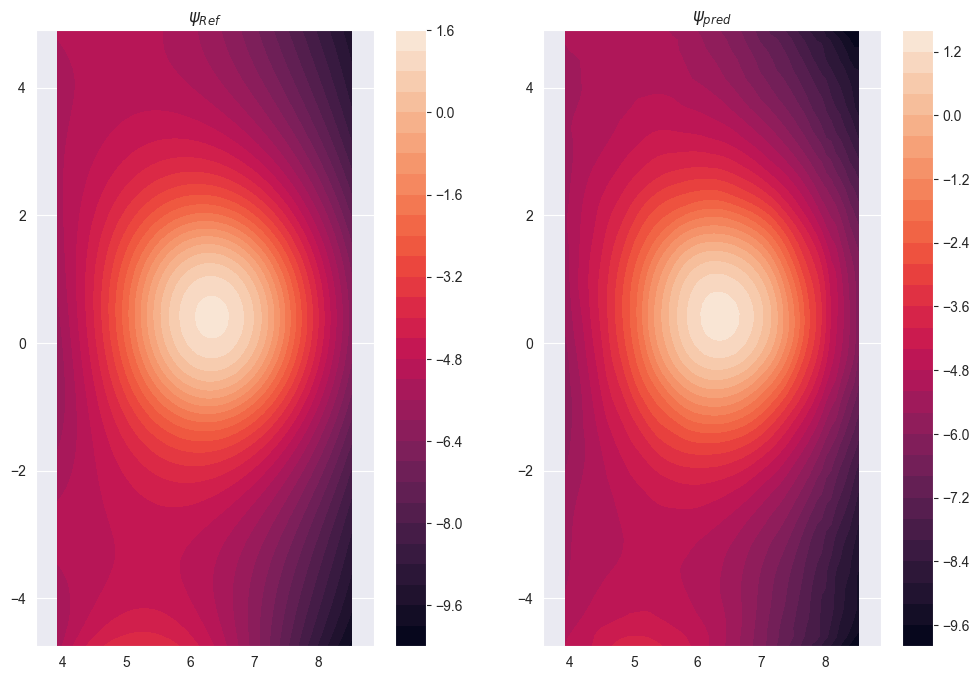

In [36]:
plt.figure(figsize=(12,8))
#plt.suptitle(f"Sample index {idx} (Test)")
plt.subplot(1,2,1)
plt.title("$\psi_{Ref}$")
plt.contourf(RR_pixels, ZZ_pixels, psi_ref.squeeze(), 30)
plt.colorbar()
plt.axis('equal')
plt.subplot(1,2,2)
plt.title("$\psi_{pred}$")
plt.contourf(RR_pixels, ZZ_pixels, psi_pred.squeeze().detach().numpy(), 30)
plt.colorbar()
plt.axis('equal')

In [37]:
model.save_checkpoint(save_folder='./checkpoints/', save_name='example_fno')

In [39]:
y_pred_test  = np.array([model(xdata["x"].unsqueeze(0).to(device)).cpu().squeeze().detach().numpy() for xdata in test_dataset])

In [47]:
y_test_flat = y_test.reshape(y_test.shape[0], -1)
y_pred_test_flat = y_pred_test_flat.reshape(y_pred_test_flat.shape[0], -1)

In [48]:
r2_test  = r2_score(y_test_flat,  y_pred_test_flat)

In [49]:
mse_test  = mean_squared_error(y_test_flat,  y_pred_test_flat)

In [50]:
print(f"R²={r2_test:.4f}")
print(f"MSE={mse_test:.6e}")

R²=0.9995
MSE=1.714055e-02
